## Linear CBwK Experiments (SquareCBwK, LinUCB)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate Linear CBwK Environment



### Reward/Cost

1. Reward is given by $r_{t,a}:=\langle x_{t,a}, \theta_0\rangle + \epsilon_t$, costs are given by $c_{t,i}:=\langle x_t, \theta_i\rangle + \epsilon_t, i \in[d].$
2. The regret is computed as $$ \text{OPT} - \sum_{t = 1}^\tau r_{t,a_t} $$

To make OPT tractable, we consider the following simpfied setting: $\mathcal{X}$ are sampled from Unif $(S^{m-1})\cap [0,1]^m$ and fixed before the game. At every round, $x_{t,a} = x_{a}$(i.e., $P_X$ is a dirac distribution). Then we can solve the OPT value from the following Linear Programming.

\begin{align*}
\text{maximize}_{ \mathbf p \in \Delta} & \sum_{a} p_{a} x_{a}^T \theta_0 \\
\text{subject to} &  \sum_{a} p_{a}  \theta_{i}^T x_{a} \leq B/T,\quad \forall i \in [d]
\end{align*}


### Parameter Generation
For $K,d \leq m-1, d \geq 4$
1. Set  $ x_{a} = \frac{1}{\sqrt{2}} (e_1 + e_{a+1}), a \in [K]$
2. Set  $ \mu = \frac{1}{\sqrt{2}} (e_1 + e_{2})$, 
3. Set $c_1 =  \frac{1}{\sqrt{2}} (e_1 + e_{3})$
4. Set $c_2 =  \frac{1}{2} (e_2 + e_{3} +  e_4 + e_5)$
5. For $i \geq 3,$ set $c_i = e_{i+1}$

In [2]:
#dim = m,num = K in X, d+1 in Theta
def Data_Generation_X_deter(num,dim):
    # num <= dim -1 
    X = np.eye(num, M = dim - 1)
    X = 1/np.sqrt(2) * np.concatenate((np.ones((num,1)),X),axis = 1)
    #X[2:,0] = 0.0
    return X # shape (K,m)

def Data_Generation_Theta_deter(num,dim):
    Theta = np.zeros((num,dim))
    Theta[0,0:2] = 1/np.sqrt(2)  * np.ones((1,2))
    Theta[1,0] = 1/np.sqrt(2)
    Theta[1,2] = 1/np.sqrt(2)
    Theta[2,1:5] = 0.5 * np.ones((1,4))
    Theta[3:,:] = np.concatenate((np.zeros((num-3,3 )), np.eye(num - 3, M = dim - 3)),axis = 1)

    
    return Theta # shape(d+1,m)


In [3]:
import scipy.optimize as optimize
def Simulate_Data(m,d,K,B,T):
    contexts = Data_Generation_X_deter(K,m)
    Theta = Data_Generation_Theta_deter(d+1,m)
    D = Theta @ contexts.T
    reward_vector = D[0,:]
    cost_matrix = D[1:,:]
    simplex_constriant = np.ones_like(reward_vector)
    A_ub = np.concatenate([cost_matrix,simplex_constriant[None,:]],axis = 0)
    #print(np.shape(A_ub))
    #print(np.size(reward_vector))

    b_ub = B/T * np.ones_like(A_ub[:,0])
    b_ub[d] = 1
    LP_solution = optimize.linprog( -reward_vector, A_ub, b_ub.T )
 #   print(LP_solution)
    optimal_allocation = LP_solution.x
    OPT = -1 *LP_solution.fun
    #print('OPT',OPT * T)
    return contexts,Theta,OPT,np.array(optimal_allocation)

# SquareCBwK Algorithm

In [4]:
T = 1000
m = 8
d = 5
K = 5
B = T/4
Z = T/B
optimal_allocation = 0


def Simulation_CBwK( T,m,d,K,B, simulation_round = 10, online_oracle = 'Newton '):
    np.random.seed(0)
    
    Est_list = []
    Reg_list = []
    OPT_list = []
    Reward_list = []
    allocation_list = []
    gamma = 2 * np.sqrt(K * T / (m*np.log(T)))
    contexts,Theta,OPT,optimal_allocation =  Simulate_Data(m,d,K,B,T)
    if online_oracle == 'OGD':
        gamma = 2 *  np.sqrt(K) * (T ** 0.25)
#     for t in range(simulation_round):
# #         contexts_set.append(contexts)
# #         Theta_set.append(Theta)
# #         OPT_set.append(OPT)
# #         optimal_allocation_set.append(optimal_allocation)


    for t in range(simulation_round):
        Resource = B * np.ones((d,1))
        hat_Theta = np.ones((d+1,m))/np.sqrt(m) 


        D_hat = hat_Theta @ contexts.T
        reward_value = D_hat[0,:] # numpy array with size (K,)
        reward_value = reward_value[None,:] # numpy array with size (1,K)
        cost_value = D_hat[1:,:] # numpy array with size (d,K)
        action_allocation = np.zeros(K,)
        lamb = np.ones((d+1,1))/(d+1) # numpy array with size (d,1)
        step_size = 1.5
        dual_step_size = 2 * np.log(d) / np.sqrt(T)
        #gamma = np.sqrt(K*T)
        Z = T/B
        total_reward = 0
        empirical_cov = (step_size ** 2) * np.eye(m) #  numpy array with size (m,m)
        noise_std = 0.2
        for t in range(T):
            if np.min(Resource) < 2 or t == (T - 2): 
#                 print('K = ',K, 'd = ',d, 'm = ', m)
#                print('Resource consumed, Algorithm Stop at step ',t + 1,'/',T)
#                print('Total reward: ',total_reward.item() )
#                 print('Regret = ', T*OPT - total_reward.item() )
#                 print('Normalized Regret = ', (T*OPT - total_reward.item())/np.sqrt(T))
                Reward_list.append(total_reward.item())
                OPT_list.append(T*OPT )
                Reg_list.append(T*OPT - total_reward.item())
                Est_list.append(sum(abs(hat_Theta - Theta)) ** 2)
                allocation_list.append(action_allocation)
               # print('Stopped at ',t)
                break
            
            # Make action
            a = np.argmax(Lagrangian_sampling(reward_value.T, cost_value.T, Z, lamb[0:d,:], gamma))
            action_allocation[a] = action_allocation[a] + 1
            # Get feedback
            #print(a)
    
#             if a == 0:
#                 continue
#             else: 
            #print('non-null!')
            x = contexts[a,:,None] #numpy array, (m,1)
            observation =  Theta @ x
            observation = observation + noise_std * np.random.randn(*np.shape(observation)) 
            #print('shape:',observation.shape)
            grad = compute_gradient(x.T , observation, hat_Theta) # compute the gradient in linear setting.

            if online_oracle == 'OGD':
                #OGD update
                hat_Theta = OGD_update(hat_Theta,grad,step_size)
                step_size = 1/np.sqrt(T+1)
            else:
                #Newton update 

                empirical_cov = empirical_cov + x @ x.T
                inv_Hessian = np.linalg.inv(empirical_cov)
                hat_Theta = NGD_update(hat_Theta, grad, inv_Hessian, step_size)

            total_reward =  total_reward + (Theta @ x)[0]
            Resource = Resource - observation[1:,:]
            #update reward value
            D_hat = hat_Theta @ contexts.T
            reward_value = D_hat[0,:] # numpy array with size (K,)
            reward_value = reward_value[None,:] # numpy array with size (1,K)
            cost_value = D_hat[1:,:] # numpy array with size (d,K)
            #update lambda
            dual_grad = ( B/T * np.ones((d,1)) - observation[1:,:])
            lamb = OMD_update(lamb, dual_grad, dual_step_size)

            
    
    return Reg_list,OPT_list,Reward_list,Est_list,allocation_list




def Lagrangian_sampling(reward_value, cost_value , Z, lamb, gamma):
    # reward_value: numpy array with shape (K,1)
    # cost_value: numpy array with shape (K,d)  
    # lamb: numpy array with shape (d,1)
    # gamma: scalar
    # Return a K+1 dimensional distribution, where the 0-th componment is the probability of pulling null arm.
    
    NonNull_value =  (reward_value + Z * ( B/T - cost_value) @ lamb).reshape(-1) # non-null values numpy array with shape (K,)
    #print('NonNull_value',NonNull_value)
    #Null_value = Z * (B/T) # scalar
    #print('Null_value',Null_value)

    #Lagrangian_value = np.insert(NonNull_value,0,Null_value)
    Lagrangian_value = NonNull_value
    #print('Lagrangian_value',Lagrangian_value)
    
    Optimal_Index = np.argmax(Lagrangian_value) #  index of optimal empirical arm
    #print('Optimal_Index:',Optimal_Index)

    Lagrangian_gap = Lagrangian_value[Optimal_Index] - Lagrangian_value # numpy array with shape (K,)

    Lagrangian_score = 1/(K + gamma * Lagrangian_gap) # numpy array with shape (K,)
    Lagrangian_score[Optimal_Index] = (
        1.0 - np.sum(Lagrangian_score[:Optimal_Index]) -  np.sum(Lagrangian_score[Optimal_Index+1:]))
    # numpy array with shape (K,)
    #print('Lagrangian_score:',Lagrangian_score)
    #print(np.sum(Lagrangian_score))
    return np.random.multinomial(1,Lagrangian_score)


def OMD_update(old_lamb, gradient, stepsize):
    # old_lamb: numpy array with shape (d,1)
    # gradient: numpy array with shape (d,1)
    # stepsize: scalar
    padded_gradient = np.insert(gradient,d,0.0)
#     print(gradient)
#     print(padded_gradient)
#     print(old_lamb)
    new_lamb = old_lamb * np.exp(-stepsize * padded_gradient[:,None])
    new_lamb = new_lamb / np.sum(new_lamb)
    return new_lamb


def OGD_update(theta, grad, step_size):
    #theta:  numpy array with shape (d+1,m)
    #gradient: numpy arrary with shape (d+1,m)
    #step_size: scalar
    theta_new = theta - step_size * grad
    
    # add projection step
    if (np.sum(theta_new ** 2) > 1):
        theta_new = theta_new/np.sqrt(np.sum(theta_new ** 2))
    theta_new[theta_new<0] = -theta_new[theta_new<0]
    return theta_new

def NGD_update(theta, grad, inv_Hessian, step_size):
    # theta:  numpy array with shape (m,d+1)
    # gradient: numpy arrary with shape (d+1,m)
    # Hessian: numpy arrary with shape (d+1,m,m)
    # step_size: scalar
    
    theta_new = theta - (step_size * inv_Hessian @ grad[:,:,None])[:,:,0]
    
    if (np.sum(theta_new ** 2) > 1):
        theta_new = theta_new/np.sqrt(np.sum(theta_new ** 2))
    theta_new[theta_new<0] = -theta_new[theta_new<0]
    return theta_new    


def compute_gradient(x, y, Theta): # compute the gradient in linear setting.
    #x: numpy array with shape (1,m)
    #y:  numpy array with shape (d+1,1)
    #Theta:  numpy array with shape (d+1,m)
    D = Theta @ x.T
    grad = 2 * (D - y) @ x
    #print(np.shape(grad))
    return grad
    

# LinCBwK Algorithm

In [5]:
def Simulation_CBwK_UCB(T,m,d,K,B, simulation_round = 10):
    np.random.seed(0)
    Est_list = []
    Reg_list = []
    OPT_list = []
    Reward_list = []
    allocation_list = []
    contexts,Theta,OPT,optimal_allocation =  Simulate_Data(m,d,K,B,T)
    penalty_list = []

    for t in range(simulation_round):
        cumulative_observation = 0

        Resource = B * np.ones((d,1))
        hat_Theta = np.ones((d+1,m))/np.sqrt(m) 
        mu_hat = np.ones((1,m))/np.sqrt(m)
        C_hat = np.ones((d,m))/np.sqrt(m)
        inv_Cov = np.eye(m)

        D_hat = hat_Theta @ contexts.T
        reward_value = D_hat[0,:] # numpy array with size (K,)
        reward_value = reward_value[None,:] # numpy array with size (1,K)
        cost_value = D_hat[1:,:] # numpy array with size (d,K)
        action_allocation = np.zeros(K,)
        lamb = np.ones((d+1,1))/(d+1) # numpy array with size (d,1)
        dual_step_size = 2 * np.log(d) / np.sqrt(T)
        #gamma = np.sqrt(K*T)
        Z = T/B
        total_reward = 0
        empirical_cov =  np.eye(m) #  numpy array with size (m,m)
        noise_std = 0.2
        for t in range(T):
            if np.min(Resource) < 2 or t == (T - 2): 
                Reward_list.append(total_reward.item())
                OPT_list.append(T*OPT )
                Reg_list.append(T*OPT - total_reward.item())
                Est_list.append(sum(abs(hat_Theta - Theta)) ** 2)
                allocation_list.append(action_allocation)
                #print('Stopped at ',t)
                break
            
            # Make action

            beta =  np.sqrt(m)


            UCB_value = compute_UCB(mu_hat.T,beta, contexts[:,:,None], inv_Cov) # (K,1)
            LCB_value,penalty = compute_LCB(C_hat.T,beta, contexts[:,:,None], inv_Cov)  # (K,d)
            score =  UCB_value -  Z * LCB_value @ lamb[:d,:] # (K,1) + (K,d)  @ (d,1)
            a = np.argmax(score)
            action_allocation[a] = action_allocation[a] + 1
            x = contexts[a,:,None] #numpy array, (m,1)
            observation =  Theta @ x
            observation = observation + noise_std * np.random.randn(*np.shape(observation)) #shape (d+1,1)
            empirical_cov = empirical_cov + x @ x.T
            cumulative_observation = cumulative_observation + (x @ observation.T) 
            inv_Cov = np.linalg.inv(empirical_cov)
            Least_Squared_solution = np.linalg.inv(empirical_cov) @ cumulative_observation # shape (m, d+1 )
            Least_Squared_solution = Least_Squared_solution.T # (d+1,m)
            mu_hat = Least_Squared_solution[0,:] #(1,m)
            mu_hat = mu_hat[None,:]
            C_hat = Least_Squared_solution[1:,:] #(d,m)
            penalty_list.append(LCB_value)
            
            total_reward =  total_reward + (Theta @ x)[0]
            Resource = Resource - observation[1:,:]
            #update lambda
            dual_grad = ( B/T * np.ones((d,1)) - observation[1:,:])
            lamb = OMD_update(lamb, dual_grad, dual_step_size)
    
    return Reg_list,OPT_list,Reward_list,Est_list,allocation_list,penalty_list


def compute_UCB(mu_hat, beta, contexts, inv_Cov):
    # mu_hat: (m,1)
    # contexts: (K,m,1)
    # beta: scalar
    # inv_Cov: (m,m)
    UCB = contexts.transpose(0,2,1) @ mu_hat[None,:,:]  +  beta * np.sqrt(contexts.transpose(0,2,1) @ inv_Cov @  contexts)
    
    return UCB[:,:,0] # (K,1)




def compute_LCB(C_hat, beta, contexts, inv_Cov):
    # mu_hat: (m,d)
    # contexts: (K,m,1)
    # beta: scalar
    # inv_Cov: (m,m)
    #print(np.sqrt(contexts.transpose(0,2,1) @ inv_Cov @  contexts))
    LCB = contexts.transpose(0,2,1) @ C_hat[None,:,:]  -  beta * np.sqrt(contexts.transpose(0,2,1) @ inv_Cov @  contexts)
    #print(LCB.shape)
    return LCB[:,0,:], np.sqrt(contexts.transpose(0,2,1) @ inv_Cov @  contexts) # (K,d)



## Dependency in m (dimension)

In [6]:
K = 3
T = 2000
B = T/4
d = 4

m_list = []
m_list_ogd = []
m_list_ucb = []
m_range = np.linspace(10,100,19).astype(int)
for m in m_range:
    #Newton
    result,_,_,_,_ = Simulation_CBwK(T, m ,d ,K, B)
    #print('m:',m,'Regret_Newton:', np.average(result),'std',np.std(result))
    m_list.append(result)
    #OGD
    result,_,_,_,_ = Simulation_CBwK(T, m ,d ,K, B, online_oracle = 'OGD')
    #print('m:',m,'Regret_OGD:', np.average(result),'std',np.std(result))
    m_list_ogd.append(result)
    #UCB
    result,_,_,_,_,_ = Simulation_CBwK_UCB(T, m ,d ,K, B)
    #print('m:',m,'Regret_UCB:', np.average(result),'std',np.std(result))
    m_list_ucb.append(result)


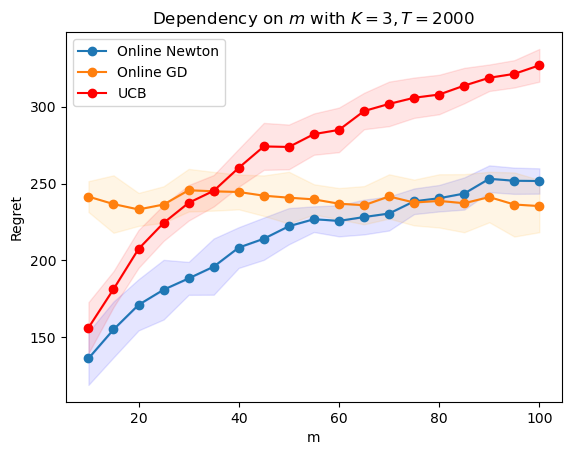

In [7]:
m_range = np.linspace(10,100,19).astype(int)

m_mean = np.mean(m_list,axis = 1)
m_mean = m_mean #- m_mean[0]
m_std = np.std (m_list,axis = 1)
#NEWTON
plt.plot(m_range,m_mean,'o-',label = 'Online Newton')
plt.fill_between(m_range,m_mean,m_mean + m_std,color = 'blue',alpha = 0.1)
plt.fill_between(m_range,m_mean,m_mean - m_std, color = 'blue',alpha = 0.1)
#OGD
m_ogd_mean = np.mean(m_list_ogd,axis = 1)
m_ogd_mean = m_ogd_mean# - m_ogd_mean[0]
m_ogd_std = np.std (m_list_ogd,axis = 1)
plt.plot(m_range,m_ogd_mean,'o-',label = 'Online GD')
plt.fill_between(m_range,m_ogd_mean,m_ogd_mean + m_ogd_std,color = 'orange',alpha = 0.1)
plt.fill_between(m_range,m_ogd_mean,m_ogd_mean - m_ogd_std, color = 'orange',alpha = 0.1)
#UCB
m_ucb_mean = np.mean(m_list_ucb,axis = 1)
m_ucb_mean = m_ucb_mean# - m_ucb_mean[0]
m_ucb_std = np.std (m_list_ucb,axis = 1)
plt.plot(m_range,m_ucb_mean,'o-',color = 'red',label = 'UCB')
plt.fill_between(m_range,m_ucb_mean,m_ucb_mean + m_ucb_std,color = 'red',alpha = 0.1)
plt.fill_between(m_range,m_ucb_mean,m_ucb_mean - m_ucb_std, color = 'red',alpha = 0.1)

plt.xlabel('m')

plt.ylabel('Regret')

plt.title('Dependency on $m$ with $K = 3, T = 2000$')
plt.legend()


## Dependency in K (arm number)

In [8]:
m = 52
T = 2000
B = T/4
d = 4
K_list_Newton = []
K_list_ogd = []
K_list_ucb = []

for K in np.linspace(5,51,10).astype(int):
    #NEWTON
    result,_,_,_,_ = Simulation_CBwK(T, m ,d ,K, B)
    #print('K:',K,'Regret:', np.average(result),'std',np.std(result))
    K_list_Newton.append(result)
    #OGD
    result,_,_,_,_ = Simulation_CBwK(T, m ,d ,K, B,online_oracle='OGD')
    #print('K:',K,'Regret:', np.average(result),'std',np.std(result))
    K_list_ogd.append(result)
    #UCB
    result,_,_,_,_,_ = Simulation_CBwK_UCB(T, m ,d ,K, B)
    #print('K:',K,'Regret:', np.average(result),'std',np.std(result))
    K_list_ucb.append(result)   

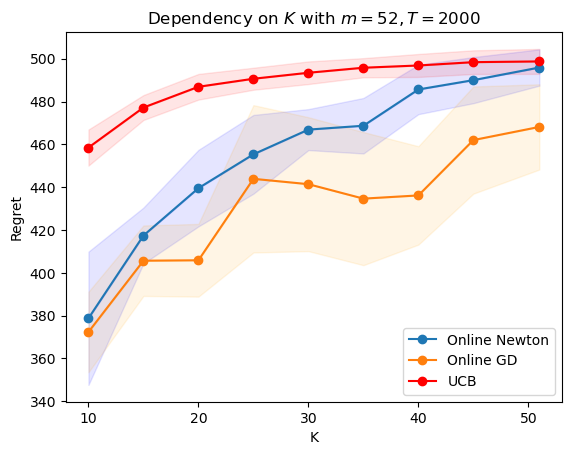

In [9]:
K_split = np.linspace(5,51,10).astype(int)
K_newton_mean = np.mean(K_list_Newton,axis = 1)
K_newton_mean = K_newton_mean #- K_newton_mean[0]
K_newton_std = np.std (K_list_Newton,axis = 1)
#NEWTON
K_split = K_split[1:]
K_newton_mean = K_newton_mean[1:]
K_newton_std = K_newton_std[1:]
plt.plot(K_split,K_newton_mean,'o-',label = 'Online Newton')
plt.fill_between(K_split,K_newton_mean,K_newton_mean + K_newton_std,color = 'blue',alpha = 0.1)
plt.fill_between(K_split,K_newton_mean,K_newton_mean - K_newton_std, color = 'blue',alpha = 0.1)
#OGD
K_ogd_mean = np.mean(K_list_ogd,axis = 1)
K_ogd_mean = K_ogd_mean #- K_ogd_mean[0]
K_ogd_std = np.std (K_list_ogd,axis = 1)
K_ogd_mean = K_ogd_mean[1:]
K_ogd_std = K_ogd_std[1:]
plt.plot(K_split,K_ogd_mean,'o-',label = 'Online GD')
plt.fill_between(K_split,K_ogd_mean,K_ogd_mean + K_ogd_std,color = 'orange',alpha = 0.1)
plt.fill_between(K_split,K_ogd_mean,K_ogd_mean - K_ogd_std, color = 'orange',alpha = 0.1)
#UCB
K_ucb_mean = np.mean(K_list_ucb,axis = 1)
K_ucb_mean = K_ucb_mean #- K_ucb_mean[0]
K_ucb_mean = K_ucb_mean[1:]
K_ucb_std = np.std (K_list_ucb,axis = 1)
K_ucb_std = K_ucb_std[1:]
plt.plot(K_split,K_ucb_mean,'o-',color = 'red',label = 'UCB')
plt.fill_between(K_split, K_ucb_mean, K_ucb_mean + K_ucb_std, color = 'red',alpha = 0.1)
plt.fill_between(K_split, K_ucb_mean, K_ucb_mean - K_ucb_std, color = 'red',alpha = 0.1)

plt.xlabel('K')

plt.ylabel('Regret')

plt.title('Dependency on $K$ with $m = 52 , T = 2000$')
plt.legend()


## Dependency in T (time horizon), small m 

In [10]:
K = 3
m = 5
T_range = 12010

In [11]:
Time_split = np.arange(1000,T_range,1000).astype(int)
regret = []
regret_line= []

regret_ogd = []
regret_line_ogd  = []

regret_ucb = []
regret_line_ucb  = []

B_split = (Time_split/4)
for index in range(len(Time_split)):
    #NEWTON
    result,_,_,_,_  = Simulation_CBwK(Time_split[index],m,d,K,B_split[index])
    #print('T = ',Time_split[index],': ' ,np.mean(result) ,'STD: ',np.std(result))# / ((1000 ** 0.5) * (np.log(1000)) ))
    regret_line.append(np.median(result))
    regret.append(result)
    #OGD
    result,_,_,_,_  = Simulation_CBwK(Time_split[index],m,d,K,B_split[index],online_oracle = 'OGD')
    #print('T = ',Time_split[index],': ' ,np.mean(result) ,'STD: ',np.std(result) )# / ((1000 ** 0.5) * (np.log(1000)) ))
    regret_line_ogd.append(np.median(result))
    regret_ogd.append(result)
    #UCB
    result,_,_,_,_,_  = Simulation_CBwK_UCB(Time_split[index],m,d,K,B_split[index])
    #print('T = ',Time_split[index],': ' ,np.mean(result) ,'STD: ',np.std(result) )# / ((1000 ** 0.5) * (np.log(1000)) ))
    regret_line_ucb.append(np.median(result))
    regret_ucb.append(result)


(0.0, 1280.0)

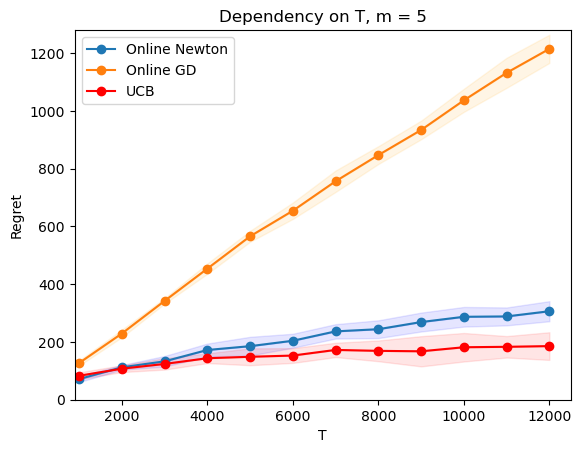

In [12]:
#Newton
regret_std = np.std(regret,axis = 1)
plt.plot(Time_split,regret_line,'-o',label = 'Online Newton')
plt.fill_between(Time_split,regret_line,regret_line + regret_std,color = 'blue',alpha = 0.1)
plt.fill_between(Time_split,regret_line,regret_line - regret_std, color = 'blue',alpha = 0.1)
#Online GD
regret_std_ogd = np.std(regret_ogd,axis = 1)
plt.plot(Time_split,regret_line_ogd ,'-o',label = 'Online GD')
plt.fill_between(Time_split,regret_line_ogd,regret_line_ogd + regret_std_ogd,color = 'orange',alpha = 0.1)
plt.fill_between(Time_split,regret_line_ogd,regret_line_ogd - regret_std_ogd, color = 'orange',alpha = 0.1)
#
regret_std_ucb = np.std(regret_ucb,axis = 1)
plt.plot(Time_split,regret_line_ucb,'o-',color = 'red',label = 'UCB')
plt.fill_between(Time_split,regret_line_ucb,regret_line_ucb + regret_std_ucb,color = 'red',alpha = 0.1)
plt.fill_between(Time_split,regret_line_ucb,regret_line_ucb - regret_std_ucb, color = 'red',alpha = 0.1)


plt.legend()
#plt.plot(Time_split,0.3 * np.sqrt(Time_split) * np.log(Time_split))
plt.xlim([900,12500])

plt.xlabel('T')

plt.ylabel('Regret')
plt.title('Dependency on T, m = 5')
plt.ylim([0,1280])

## Dependency in T (time horizon), large m 

In [13]:
K = 3
m = 52
T_range = 12010

In [14]:
Time_split = np.arange(1000,T_range,1000).astype(int)
regret = []
regret_line = []

regret_ogd = []
regret_line_ogd  = []

regret_ucb = []
regret_line_ucb  = []
B_split = (Time_split/4)
for index in range(len(Time_split)):
    #Newton
    result,_,_,_,_  = Simulation_CBwK(Time_split[index],m,d,K,B_split[index])
    #print('T = ',Time_split[index],': ' ,np.mean(result) ,'STD: ',np.std(result))# / ((1000 ** 0.5) * (np.log(1000)) ))
    regret_line.append(np.median(result))
    regret.append(result)
    #OGD
    result,_,_,_,_  = Simulation_CBwK(Time_split[index],m,d,K,B_split[index],online_oracle = 'OGD')
    #print('T = ',Time_split[index],': ' ,np.mean(result) ,'STD: ',np.std(result) )# / ((1000 ** 0.5) * (np.log(1000)) ))
    regret_line_ogd.append(np.median(result))
    regret_ogd.append(result)
    #UCB
    result,_,_,_,_,_  = Simulation_CBwK_UCB(Time_split[index],m,d,K,B_split[index])
    #print('T = ',Time_split[index],': ' ,np.mean(result) ,'STD: ',np.std(result) )# / ((1000 ** 0.5) * (np.log(1000)) ))
    regret_line_ucb.append(np.median(result))

    regret_ucb.append(result)
   

Text(0.5, 1.0, 'Dependency on T with m = 52, K = 3')

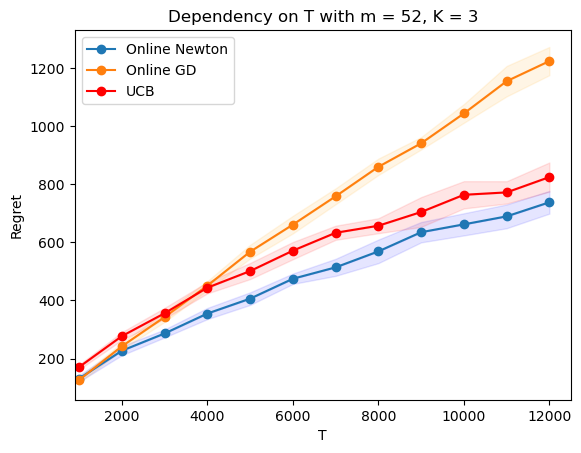

In [15]:
#Newton
regret_std = np.std(regret,axis = 1)
plt.plot(Time_split,regret_line,'-o',label = 'Online Newton')
plt.fill_between(Time_split,regret_line,regret_line + regret_std,color = 'blue',alpha = 0.1)
plt.fill_between(Time_split,regret_line,regret_line - regret_std, color = 'blue',alpha = 0.1)
#Online GD
regret_std_ogd = np.std(regret_ogd,axis = 1)
plt.plot(Time_split,regret_line_ogd ,'-o',label = 'Online GD')
plt.fill_between(Time_split,regret_line_ogd,regret_line_ogd + regret_std_ogd,color = 'orange',alpha = 0.1)
plt.fill_between(Time_split,regret_line_ogd,regret_line_ogd - regret_std_ogd, color = 'orange',alpha = 0.1)
#UCB
regret_std_ucb = np.std(regret_ucb,axis = 1)
plt.plot(Time_split,regret_line_ucb,'o-',color = 'red',label = 'UCB')
plt.fill_between(Time_split,regret_line_ucb,regret_line_ucb + regret_std_ucb,color = 'red',alpha = 0.1)
plt.fill_between(Time_split,regret_line_ucb,regret_line_ucb - regret_std_ucb, color = 'red',alpha = 0.1)


plt.legend()
#plt.plot(Time_split,0.3 * np.sqrt(Time_split) * np.log(Time_split))
plt.xlim([900,12500])

plt.xlabel('T')

plt.ylabel('Regret')
plt.title('Dependency on T with m = 52, K = 3')
#plt.ylim([0,500 * 15 / (14)])